In [222]:
import msprime as msp
import matplotlib.pyplot as plt
import numpy as np
from concurrent.futures import ThreadPoolExecutor
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from IPython.display import SVG

Basic assumptions, taken from [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1462041/pdf/11973287.pdf)
- Assuming an effective population size of $N_e\approx 5\times 10^3$ .
- Mutation rate: $\mu = 2.5\times 10^{-5}$ per generation.
- Recombination rate: same.
- Generation time: 1.5 days/gen
- Genome length: $10^4$ bp.

In [223]:
params = dict(
    length=1e4,
    recombination_rate=2.5e-5,
    Ne=5e3
)

In [224]:
def parallel_simulate(f, n_replicates=2, seed=1, *args, **kwargs):
    np.random.seed(seed)
    def g(i):
        return f(msp.simulate(*args, random_seed=i + 1, **kwargs))
    with ThreadPoolExecutor() as p:
        futures = [p.submit(g, np.random.randint(1, int(4e9))) 
                   for _ in range(n_replicates)]
        return [fut.result() for fut in futures]

## Basic model
No latent population, no selection. Ten samples taken at present (homochronous) from host.

Average number of recombinations:

In [225]:
def num_recomb(sim):
    return len(list(sim.trees()))

p = dict(sample_size=10, **params)

np.mean(parallel_simulate(num_recomb, **p))

10967.5

Average GTMRCA (generations):

In [226]:
def gtmrca(sim):
    return max(
        t.time(t.root) for t in sim.trees()
    )
gt = np.mean(parallel_simulate(gtmrca, **p))

Infections do not reach a common ancestor under this model.

In [227]:
gt / 1.5 / 365

200.91413007752925

## Heterochronous sampling
Five samples taken once a year for three years.

In [228]:
sampling_interval = 365 / 1.5
p = dict(samples=[x for i in range(3)
         for x in [(0, i * sampling_interval)] * 5],
         **params)
np.mean(parallel_simulate(num_recomb, **p))

14001.0

In [229]:
np.mean(parallel_simulate(gtmrca, **p))

128578.98524566577

## Periodic sweeps
We model the effects of selection by introducing periodic bottlenecks at one year intervals for a ten-year period. The effective population size crashes to $N_e=10$ after each sweep. The growth rate is calculated such that $N_e=5\times 10^3$ immediately before the sweep.

In [230]:
sweep_interval = 365 / 1.5
g = np.log(1e2 / 5e3) / -sweep_interval
de = [
    msp.PopulationParametersChange(time=t * sweep_interval, 
                                   initial_size=5e3, 
                                   growth_rate=g)
    for t in range(10)
]
msp.DemographyDebugger(demographic_events=de).print_history()

Events @ generation 0
   - Population parameter change for -1: initial_size -> 5000.0 growth_rate -> 0.016076806871622516 
Epoch: 0 -- 0.0 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |    1        1                 0 |     0    

Epoch: 0.0 -- 243.33333333333334 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  5e+03     100           0.0161 |     0    

Events @ generation 243.33333333333334
   - Population parameter change for -1: initial_size -> 5000.0 growth_rate -> 0.016076806871622516 
Epoch: 243.33333333333334 -- 486.6666666666667 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  5e+03     100           0.0161 |     0    

Events @ generation 486.6666666666667
   - Population parameter change for -1: initial_size -> 5000.0 growth_rate -> 0.016076806871622516 
Epoch: 486.6666666666667 -- 730

Average number of recombinations:

In [231]:
sampling_interval = 365 / 1.5
samples = [x for i in range(3) for x in [(0, i * sampling_interval)] * 5]
p = dict(samples=samples,
         demographic_events=de,
         **params)

Many fewer recombination events assuming this type of demography.

In [232]:
np.mean(parallel_simulate(num_recomb, **p))

1539.0

Average GTMRCA (generations):

In [233]:
def gtmrca(sim):
    return max(
        t.time(t.root) for t in sim.trees()
    )
gt = np.mean(parallel_simulate(gtmrca, **p))
gt

2607.516639612739

Since $2600 \times 1.5 / 365 \approx 10$ the expected grand MRCA is still about ten years back under this model.

## Latency

Finally, we add in a latent reservoir with periodic recolonization. The latent pool has a large effective population size indicating a general lack of drift. 

In [234]:
de = [
    msp.PopulationParametersChange(time=t * sweep_interval, 
                                   initial_size=5e3, 
                                   growth_rate=g,
                                   population=0)
    for t in range(10)
]
de += [
    msp.MassMigration(time=ev.time - 1, destination=1, source=0, proportion=.5)
    for ev in de
    if ev.time > 0
]
# The latent and blood reservoirs diverged (say) 10 years ago.
de.append(msp.MassMigration(time = 10 * sweep_interval, 
                            source=1, 
                            destination=0, 
                            proportion=1))
de = sorted(de, key=lambda ev: ev.time)
pc = [
    msp.PopulationConfiguration(initial_size=5e3),
    msp.PopulationConfiguration(initial_size=1e6)
]
msp.DemographyDebugger(demographic_events=de, 
                       population_configurations=pc).print_history()

Events @ generation 0
   - Population parameter change for 0: initial_size -> 5000.0 growth_rate -> 0.016076806871622516 
Epoch: 0 -- 0.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  5e+03    5e+03               0 |     0        0    
1 |  1e+06    1e+06               0 |     0        0    

Epoch: 0.0 -- 242.33333333333334 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  5e+03     102           0.0161 |     0        0    
1 |  1e+06    1e+06               0 |     0        0    

Events @ generation 242.33333333333334
   - Mass migration: lineages move from 0 to 1 with probability 0.5
Epoch: 242.33333333333334 -- 243.33333333333334 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |   102      100           0.0161 |     0        0    
1 |  1e+0

In [235]:
p = dict(samples=samples,
         population_configurations=pc,
         demographic_events=de,
         record_migrations=True,
         **params)
sim = msp.simulate(**p)

In [236]:
np.mean(parallel_simulate(num_recomb, **p))

3866.0

## Inference based on SFS

I thought it would be interesting to do a (crude) comparison of the site frequency spectrum as we vary parameters of the latent population. This completely ignores linkage so if our hypothesis that accounting for recombination is essential, then varying the parameters of the latency model should not alter the SFS much.

In [244]:
from collections import Counter
from pprint import pprint
from psmr import drop_mutations  # we will generate our own mutations
mutation_rates = [2.5e-5, 2.5e-10]  # HIV, human baseline

def sfs(sim):
    return Counter(count for pos, count in drop_mutations(sim, mutation_rates))
def f():
    d = sum(parallel_simulate(sfs, **p), Counter())
    plt.plot(
        np.arange(1, 20),
        [d[i] for i in range(1, 20)]
    )

Baseline parameters:

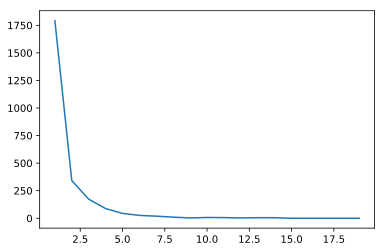

In [245]:
f()

Increase the latent pool $N_e$ by a factor of ten:

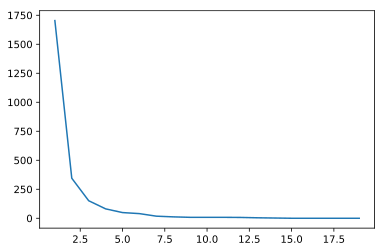

In [246]:
pc[1].initial_size = 1e7
f()

Increase the migration fraction from .5 to .9:

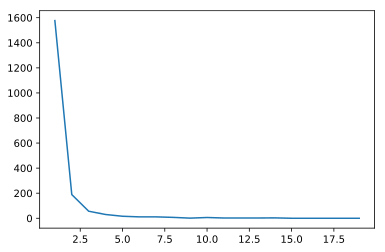

In [247]:
pc[1].initial_size = 1e6
for ev in de:
    try: 
        if ev.proportion == 0.5:
            ev.proportion = 0.9
    except AttributeError:
        pass
f()

In short there is hardly any effect on the SFS under this parameterization. Probably the simulation needs to be improved, perhaps using ideas from  [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3765939/).

(Interesting quote from said paper:

 > Thus, when HIV with its almost 10 kb genome is reverse transcribed there is about a 20% chance that a base substitution occurs. In a chronically infected patient it has been estimated that about $10^8$ cells are infected each day, thus allowing all possible single and many double mutations to be explored each day.

Check that our modified code is equivalent to the published method when mutation rates are equal:

In [251]:
mutation_rates[1] = 2.5e-5

def sfs_base(sim):
    return Counter(
        v.genotypes.sum()
        for v in sim.variants()
    )

p['mutation_rate'] = 2.5e-5

print(sum(parallel_simulate(sfs, **p), Counter()))
print(sum(parallel_simulate(sfs_base, **p), Counter()))

Counter({1: 6651, 2: 2461, 3: 1021, 4: 286, 5: 122, 6: 41, 7: 21, 8: 8, 11: 5, 12: 3, 9: 2, 13: 2, 14: 1, 10: 1})
Counter({1: 6641, 2: 2529, 3: 1018, 4: 326, 5: 104, 6: 51, 7: 27, 8: 14, 9: 7, 11: 3, 10: 3, 14: 2, 12: 2, 13: 1})
